#Importing Libraries

In [1]:
import pandas as pd
import random
from keras.layers import GRU, Dense, Dropout
import numpy as np
import matplotlib.pyplot as plt
from keras.optimizers import Adam
import seaborn as sns
import matplotlib.dates as mdates
import math
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau

#Setting random seeds for reproducibility

In [2]:
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Loading and preparing the dataset

In [3]:
df = pd.read_csv('new30.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date').reset_index(drop=True)
df.dropna(inplace=True)

df.info()
df.describe()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2338 entries, 0 to 2337
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               2338 non-null   datetime64[ns]
 1   Price              2338 non-null   float64       
 2   Open               2338 non-null   float64       
 3   High               2338 non-null   float64       
 4   Low                2338 non-null   float64       
 5   Change %           2338 non-null   float64       
 6   GDP                2338 non-null   float64       
 7   Inflation          2338 non-null   float64       
 8   FDI                2338 non-null   float64       
 9   Trade Balance      2338 non-null   float64       
 10  Unemployment Rate  2338 non-null   float64       
 11  Exchange Rate      2338 non-null   float64       
 12  Economic Growth    2338 non-null   float64       
dtypes: datetime64[ns](1), float64(12)
memory usage: 237.6 KB


,0
Date,0
Price,0
Open,0
High,0
Low,0
Change %,0
GDP,0
Inflation,0
FDI,0
Trade Balance,0


# Selecting relevant features for training

In [4]:
FEATURES = ['Price', 'Open', 'High', 'Low', 'GDP','Inflation', 'FDI', 'Trade Balance',
            'Unemployment Rate', 'Exchange Rate', 'Economic Growth']

data_filtered = df[FEATURES]
df.head()

,Date,Price,Open,High,Low,Change %,GDP,Inflation,FDI,Trade Balance,Unemployment Rate,Exchange Rate,Economic Growth
0,2013-01-30,1486.56,1486.56,1486.56,1486.56,-0.0061,6.01,7.53,2.6,10.83,4.43,77.77,6.01
1,2013-01-31,1488.56,1488.56,1488.56,1488.56,0.0013,6.01,7.53,2.6,10.83,4.43,77.82,6.01
2,2013-02-03,1494.14,1494.14,1494.14,1494.14,0.0037,6.01,7.53,2.6,10.83,4.43,77.77,6.01
3,2013-02-04,1503.97,1503.97,1503.97,1503.97,0.0066,6.01,7.53,2.6,10.83,4.43,77.77,6.01
4,2013-02-05,1518.40,1518.40,1518.40,1518.40,0.0096,6.01,7.53,2.6,10.83,4.43,77.82,6.01


# Normalizing the data using MinMaxScaler

In [5]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_filtered)

# Function to create input sequences for time series modeling

In [6]:
sequence_length = 50

def partition_dataset(sequence_length, data):
    x, y = [], []
    for i in range(sequence_length, len(data)):
        x.append(data[i-sequence_length:i, :])
        y.append(data[i, 0])  # Prediction is based on the 'Price' column
    return np.array(x), np.array(y)

# Dataset partitioning for training and testing

In [7]:
x, y = partition_dataset(sequence_length, data_scaled)
split = math.ceil(0.8 * len(x))
x_train, y_train = x[:split], y[:split]
x_test, y_test = x[split:], y[split:]

# GRU Model Architecture

In [8]:
model_gru = Sequential()
model_gru.add(GRU(256, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model_gru.add(Dropout(0.15))
model_gru.add(GRU(128, return_sequences=False))
#model_gru.add(Dropout(0.1))
model_gru.add(Dense(32, activation='relu'))
model_gru.add(Dense(1))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# Compile the model with Adam optimizer and ReduceLROnPlateau callback

In [9]:
optimizer = Adam(learning_rate=0.001, clipvalue=1.0)
model_gru.compile(optimizer=optimizer, loss='mse')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# Model training with validation split

In [10]:
history_gru = model_gru.fit(x_train, y_train, epochs=25, batch_size=32, validation_split=0.1, callbacks=[ reduce_lr])

Epoch 1/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 18s 245ms/step - loss: 0.0414 - val_loss: 6.9478e-04 - learning_rate: 0.0010
Epoch 2/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 19s 215ms/step - loss: 9.2811e-04 - val_loss: 0.0010 - learning_rate: 0.0010
Epoch 3/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 12s 235ms/step - loss: 8.6775e-04 - val_loss: 0.0011 - learning_rate: 0.0010
Epoch 4/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 20s 229ms/step - loss: 7.5433e-04 - val_loss: 0.0015 - learning_rate: 0.0010
Epoch 5/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 12s 239ms/step - loss: 8.0455e-04 - val_loss: 0.0012 - learning_rate: 2.0000e-04
Epoch 6/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 12s 237ms/step - loss: 6.8478e-04 - val_loss: 0.0012 - learning_rate: 2.0000e-04
Epoch 7/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 19s 206ms/step - loss: 7.1148e-04 - val_loss: 0.0012 - learning_rate: 2.0000e-04
Epoch 8/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 22s 233ms/step - loss: 6.7650e-04 - val_loss: 0.0011 - learning_rate: 1.0000e-04
Epoch 9/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 21s 241ms/step - loss: 7.1

# Plotting training and validation loss

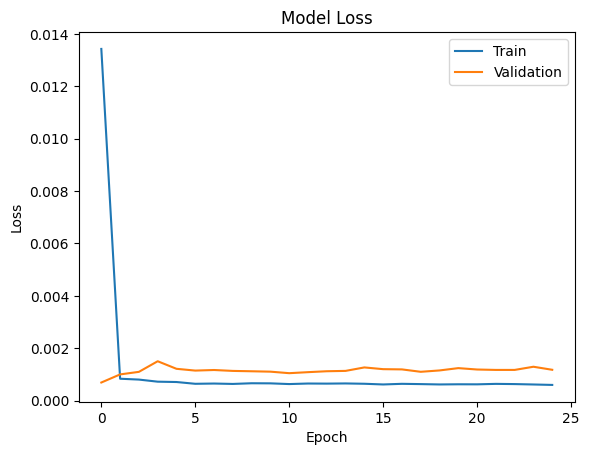

In [11]:
plt.plot(history_gru.history['loss'])
plt.plot(history_gru.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Prediction and inverse transformation

In [12]:
y_pred_scaled_gru = model_gru.predict(x_test)
y_pred_gru = scaler.inverse_transform(np.concatenate((y_pred_scaled_gru, x_test[:, -1, 1:]), axis=1))[:, 0]
y_test_unscaled = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), x_test[:, -1, 1:]), axis=1))[:, 0]

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step


# Evaluation metrics: MSE, RMSE, MAE, MAPE

In [13]:
mse_gru = mean_squared_error(y_test_unscaled, y_pred_gru)
rmse_gru = np.sqrt(mse_gru)
mae_gru = np.mean(np.abs(y_test_unscaled - y_pred_gru))
mape_gru = np.mean(np.abs((y_test_unscaled - y_pred_gru) / y_test_unscaled)) * 100

print(f'Mean Squared Error (MSE) - GRU: {mse_gru:.2f}')
print(f'Root Mean Squared Error (RMSE) - GRU: {rmse_gru:.2f}')
print(f'Mean Absolute Error (MAE) - GRU: {mae_gru:.2f}')
print(f'Mean Absolute Percentage Error (MAPE) - GRU: {mape_gru:.2f}')

Mean Squared Error (MSE) - GRU: 9405.39
Root Mean Squared Error (RMSE) - GRU: 96.98
Mean Absolute Error (MAE) - GRU: 83.16
Mean Absolute Percentage Error (MAPE) - GRU: 3.50


# Accuracy Calculation (based on trend range)

In [14]:
absolute_difference_gru = np.abs(y_test_unscaled - y_pred_gru)

mean_absolute_difference_gru = np.mean(absolute_difference_gru)

price_range_gru = np.max(y_test_unscaled) - np.min(y_test_unscaled)

accuracy_percentage_gru = (1 - (mean_absolute_difference_gru / price_range_gru)) * 100

print(f'Accuracy of Predicted Prices (GRU): {accuracy_percentage_gru:.2f}%')


Accuracy of Predicted Prices (GRU): 90.62%


# Visualization: True vs Predicted Price Trend

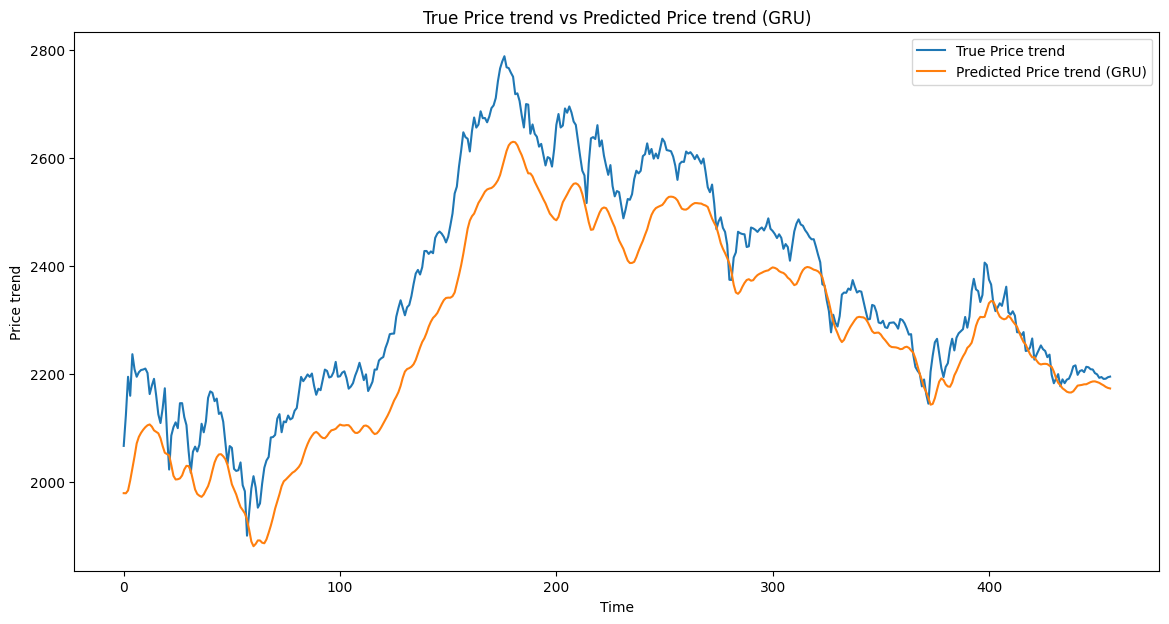

In [15]:
plt.figure(figsize=(14, 7))
plt.plot(y_test_unscaled, label='True Price trend')
plt.plot(y_pred_gru, label='Predicted Price trend (GRU)')
plt.title('True Price trend vs Predicted Price trend (GRU)')
plt.xlabel('Time')
plt.ylabel('Price trend')
plt.legend()
plt.show()